In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
from datetime import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble6'
channel = False

trans_day = 1

target_alpha = 100
future_day = 2
train_end_back = -1
n_timestep = 15
time_interval = 1
input_size = 809
n_unit = 128
batch_size = 35
learning_rate = 0.0005
epochs = 1000

alpha = 0.05
beta = 0.01
gamma = 1

comment = "예측 모델과 best share decision 모델의 reinforcing interaction,  수익률의 합으로 평가, loss=mse"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
df['close'] = df[target_column] # 종가 column 추가, 기존 종가는 rate으로 변환 예정
a = []
b = []
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha     
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]    

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가,close
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,-0.853010,0.974513,0.827681,0.373581,0.614542,-0.961538,116.55,120.25,115.95,119.60
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,-0.039689,0.193571,1.002058,0.594935,0.706918,3.381014,119.35,123.45,116.80,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,0.800355,0.031266,0.069626,0.430159,0.725768,3.292528,120.40,123.60,119.75,118.45
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.515992,0.623370,0.378121,0.084769,0.352875,1.677149,122.90,124.10,120.95,119.25
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,3.856851,0.568635,-0.322023,0.518339,0.702038,0.653862,122.40,125.05,120.40,122.35
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,2.657684,1.222974,-0.720402,0.474125,0.440887,1.319588,120.85,125.05,119.85,121.25
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,3.026664,2.114708,-0.407511,0.622228,0.721716,-1.867641,123.60,124.75,115.25,123.15
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,3.316674,1.871659,-0.157431,0.985272,1.379493,-5.575906,118.85,119.00,110.45,122.85
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,2.384344,0.988933,-0.154629,0.473525,0.907189,-8.274721,116.45,116.80,105.25,120.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,1.935983,0.085505,-0.246361,0.529501,0.923675,-1.422414,112.05,114.35,105.25,116.00


In [8]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = 1 + rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(train_y, preds)
    
    batches_float32 = tf.cast(tf.shape(train_y)[0], dtype=tf.float32)
    batches_int32 = tf.cast(tf.shape(train_y)[0], dtype=tf.int32)

    return_plus = 0.000000000
    return_minus = 0.000000000
    for i in range(batches_int32):
        if profits[i, -1, 0] - 1 > 0: return_plus += profits[i, -1, 0]-1      
        else: return_minus += 1-profits[i, -1, 0]    

    loss2 = (return_plus - return_minus)/batches_float32
    
    return loss1 - loss2


In [9]:
@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]    
    
   
    train_y_target = tf.expand_dims(train_y[:, :, 4], axis=2)
    
    rates = tf.cast(train_y_target / 100, dtype=tf.float64)
    rates_last = tf.reshape(rates[:, -1, 0], [-1])
    rates = tf.reshape(rates[:, :-1, 0], [batches, steps - 1, 1])
    rates = tf.concat([rates, np.zeros((batches, 1, 1))], 1)
    updown = tf.math.sign(train_y_target)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    #profits = tf.cast(tf.convert_to_tensor(rates, dtype=tf.float64)*tf.math.sign(preds), dtype=tf.float64)
    

    # model2 input 생성
    train_x_m2 = tf.concat([preds, rates], 2)
    y = tf.cast(m2(train_x_m2), dtype=tf.float64)
    y0 = tf.reshape(y[:, :, 0], [batches, steps, 1])
    y1 = tf.reshape(y[:, :, 1], [batches, steps, 1])
    y2 = tf.reshape(y[:, :, 2], [batches, steps, 1])
    
    # the number of shares 계산
    profits = []
    for i in range(batches):
        profits.append(y0[i]*rates[i]*tf.math.sign(preds[i]) + \
                       y1[i]*rates[i]*tf.math.sign(preds[i]) + \
                       y2[i]*rates_last[i]*tf.math.sign(preds[i]))
    profits = tf.reshape(profits, [batches, steps, 1])

    
    # maximum profits
    max_profits = []
    for i in range(batches):

        max_profits.append(tf.math.reduce_sum(tf.math.abs(rates[i, :, 0])))
    
   
    Qvalues = []
    for i in range(batches):
        
        Qvalues.append(tf.math.reduce_sum(profits[i, :, 0]))        

    
    loss = keras.losses.MSE(max_profits, Qvalues)
  
    return loss


In [10]:
def test(m1, m2, test_x, test_y):
    
    test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)
    
    rates = tf.cast(test_y_target / 100, dtype=tf.float64)
    rates = tf.reshape(rates[:, :-1, 0], [rates.shape[0], rates.shape[1] -1, 1])
    rates = tf.concat([rates, np.zeros((rates.shape[0], 1, 1))], 1)
    preds = tf.cast(m1(test_x), dtype=tf.float64)

    # model2 input 생성
    test_x_m2 = tf.concat([preds, rates], 2)
    y = m2(test_x_m2)[:, -1, :]
    shares = tf.math.argmax(y, 1)

    return shares

In [11]:
#@tf.function
def gradient1(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [12]:
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#model2 = models.LSTM_sigm(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0)

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(200)),
    tf.keras.layers.Dense(150, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])
model2.summary()

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
model1.save_weights(checkpoint_path)            

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 10)            520       
_________________________________________________________________
dense_1 (Dense)              (None, 15, 3)             33        
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [13]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []

print("실험 시작")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

while True:

    gc.collect()
    
    #model2 data
    train_data, test_data = prepro.get_train_test_data(df['종가(포인트)'], target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)  
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)


    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    
    # randomly selected  step size
    #drop_idx = np.random.randint(int(train_y.shape[1]/2))
    #train_x[:, :drop_idx, :] = 0
    #train_y[:, :drop_idx, :] = 0    
    
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]
    
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)    
    
    # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
    train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.5)    
    
    updown = np.sign(test_y[:, -1, 4]).reshape((-1))
    
    # random batch_size
    #batch_size = np.random.randint(10, 50)    

    # model1 training
    train1_y_target = np.expand_dims(train1_y[:, :, 4], axis=2)
    early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    model1.load_weights(checkpoint_path)
    model1.fit(train1_x, train1_y_target, batch_size=batch_size, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)
    
    # 자산 배분 모델 reset
    #model2 = tf.keras.Sequential([
    #    tf.keras.Input(shape=(n_timestep, 2)),
    #    tf.keras.layers.LSTM(10, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #    tf.keras.layers.Dense(64, activation='relu'),
    #    tf.keras.layers.Dense(3, activation='softmax'),
    #])    
    
    # model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_batch(train2_x, train2_y, batch_size)

        #gradients1 = gradient1(model1, model2, batch_input, batch_output)
        #optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)        
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))

        if iteration % 100 == 0:

            # model2의 test loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)   

        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    prediction2 = test(model1, model2, test_x, test_y)    
    print('optimal shares = ', prediction2)

    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 1000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']

실험 시작
2020-07-21:00:12:12
Train on 2327 samples, validate on 1 samples
Epoch 1/3
2327/2327 [==============================] - 11s 5ms/sample - loss: 24.9148 - val_loss: 14.0758
Epoch 2/3
2327/2327 [==============================] - 1s 457us/sample - loss: 12.2601 - val_loss: 7.4539
Epoch 3/3
2327/2327 [==============================] - 1s 380us/sample - loss: 6.9087 - val_loss: 5.0600

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely o

model2 loss = tf.Tensor(7.464457902958463e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.303138723826529e-07, shape=(), dtype=float64)
test dates 2019-01-09~2019-01-09
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 478us/sample - loss: 0.7965 - val_loss: 1.1237
Epoch 2/3
492/492 [==============================] - 0s 362us/sample - loss: 0.7311 - val_loss: 0.8103
Epoch 3/3
492/492 [==============================] - 0s 439us/sample - loss: 0.7312 - val_loss: 0.7996
model2 loss = tf.Tensor(7.8422291141461e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.84526039319415e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.850269097107723e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.855986208488311e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.862070871053648e-05, shape=(), dtype=

model2 loss = tf.Tensor(8.847946963695934e-11, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.745412441824204e-11, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.509717015032865e-11, shape=(), dtype=float64)
test dates 2019-01-18~2019-01-18
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 449us/sample - loss: 0.3230 - val_loss: 0.5845
Epoch 2/3
492/492 [==============================] - 0s 449us/sample - loss: 0.3045 - val_loss: 0.6212
Epoch 3/3
492/492 [==============================] - 0s 392us/sample - loss: 0.3089 - val_loss: 0.5777
model2 loss = tf.Tensor(6.529407297860869e-11, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.554371438054364e-11, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.605449315589846e-11, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.713587885026738e-11, shape=(), dty

model2 loss = tf.Tensor(9.451525211213353e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.451343392205826e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.451316819790432e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.451207664986415e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.451090321174739e-06, shape=(), dtype=float64)
test dates 2019-01-29~2019-01-29
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 432us/sample - loss: 0.2435 - val_loss: 0.6733
Epoch 2/3
492/492 [==============================] - 0s 453us/sample - loss: 0.2404 - val_loss: 0.7198
Epoch 3/3
492/492 [==============================] - 0s 352us/sample - loss: 0.2177 - val_loss: 0.8092
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.0001292113339908048, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000129

model2 loss = tf.Tensor(1.744357173881664e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7580612172072606e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7276422945224636e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7091892819621645e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7207930954450785e-13, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-02-12~2019-02-12
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 493us/sample - loss: 0.2021 - val_loss: 0.7311
Epoch 2/3
492/492 [==============================] - 0s 455us/sample - loss: 0.1889 - val_loss: 0.6524
Epoch 3/3
492/492 [==============================] - 0s 366us/sample - loss: 0.1839 - val_loss: 0.8614
model2 loss = tf.Tensor(0.00030090698812896085, shape=(), dt

Epoch 3/3
492/492 [==============================] - 0s 434us/sample - loss: 0.1901 - val_loss: 1.0950
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.00030085809421773007, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0003008581645629183, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00030085836139083527, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00030085841740506747, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0003008586479610569, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000300859020613419, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00030085920214761223, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-02-21~2019-02-21
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 579us/sample - loss: 0.1994 - val_loss:

492/492 [==============================] - 0s 569us/sample - loss: 0.1583 - val_loss: 0.2658
Epoch 2/3
492/492 [==============================] - 0s 489us/sample - loss: 0.1892 - val_loss: 0.2025
Epoch 3/3
492/492 [==============================] - 0s 472us/sample - loss: 0.1831 - val_loss: 0.2266
model2 loss = tf.Tensor(8.39748677525456e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.365984205435513e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.362643602678298e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.329766584126835e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.301993462054673e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.290685962054765e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.254258662621364e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.205657393893217e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.153517434653532e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.097131243559841e-12, shape=(

model2 loss = tf.Tensor(0.0034754169178566807, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0034754174613872263, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0034754175807878204, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0034754175358787573, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.003475418277733323, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.003475418496168824, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.003475418664883752, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-03~2019-04-03
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 484us/sample - loss: 0.1127 - val_loss: 0.7745
Epoch 2/3
492/492 [==============================] - 0s 399us/sample - loss: 0.1112 - val_loss: 0.7203
Epoch 3/3
492/492 [=======

model2 loss = tf.Tensor(3.3583613966788398e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.3583465098306023e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.3583554760697e-06, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-12~2019-04-12
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 492us/sample - loss: 0.1171 - val_loss: 0.1544
Epoch 2/3
492/492 [==============================] - 0s 406us/sample - loss: 0.1165 - val_loss: 0.1481
Epoch 3/3
492/492 [==============================] - 0s 400us/sample - loss: 0.1284 - val_loss: 0.1655
model2 loss = tf.Tensor(6.442504844168435e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.442502895147695e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.442485692337795e-05, shape=(), dtype=f

model2 loss = tf.Tensor(6.679091567583985e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.650503255029901e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.602504138185282e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.559658659914328e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.541029371521118e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.493627656169566e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.4400849584297255e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.390402704189886e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.331581623703862e-12, shape=(), dtype=float64)
test dates 2019-04-23~2019-04-23
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 494us/sample - loss: 0.1281 - val_loss: 0.2360
Epoch 2/3
492/492 [==============================

model2 loss = tf.Tensor(1.0330858007751076e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.033086036401727e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.0330868337158331e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.033087566271752e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.033086654815025e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.033087636666389e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-05-03~2019-05-03
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 414us/sample - loss: 0.1240 - val_loss: 0.7233
Epoch 2/3
492/492 [==============================] - 0s 427us/sample - loss: 0.1101 - val_loss: 0.2627
Epoch 3/3
492/492 [==============================] - 0s 384us/sample - loss: 0.1207 - val_los

model2 loss = tf.Tensor(0.0007880536181679022, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880533778078703, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880534028582605, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880533206904805, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880533381917512, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880532665832404, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880532356533144, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0007880533488998501, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-05-15~2019-05-15
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 466us/sample - loss: 0.1093 - val_loss: 0.3280
Epoch 2/3
492/492 [==============================] - 0

model2 loss = tf.Tensor(1.4768033066873836e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.4768035083165876e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.4768058609924836e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-05-24~2019-05-24
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 420us/sample - loss: 0.0932 - val_loss: 0.8513
Epoch 2/3
492/492 [==============================] - 0s 477us/sample - loss: 0.0905 - val_loss: 0.6026
Epoch 3/3
492/492 [==============================] - 0s 420us/sample - loss: 0.0937 - val_loss: 0.4192
model2 loss = tf.Tensor(0.0008515796618731174, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008515795726913704, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008515798907396399, shape=(), dtyp

model2 loss = tf.Tensor(7.673402739850271e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.673398382235935e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.673393673753968e-05, shape=(), dtype=float64)
test dates 2019-06-04~2019-06-04
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 379us/sample - loss: 0.1110 - val_loss: 0.3468
Epoch 2/3
492/492 [==============================] - 0s 318us/sample - loss: 0.0961 - val_loss: 0.4052
Epoch 3/3
492/492 [==============================] - 0s 434us/sample - loss: 0.0950 - val_loss: 0.3995
Epoch 00003: early stopping
model2 loss = tf.Tensor(3.7156573640625964e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.7054468189237686e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.6996844154940987e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.677

step :  3
Training process is stopped early....
test dates 2019-06-14~2019-06-14
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 475us/sample - loss: 0.1096 - val_loss: 0.2172
Epoch 2/3
492/492 [==============================] - 0s 448us/sample - loss: 0.0939 - val_loss: 0.1759
Epoch 3/3
492/492 [==============================] - 0s 362us/sample - loss: 0.0924 - val_loss: 0.2737
model2 loss = tf.Tensor(0.00034225819581809044, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00034225837504862417, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00034225834377914265, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00034225844129754865, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0003422584817908775, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00034225853421458567, shape=(), dtype=float64)
model2 

model2 loss = tf.Tensor(1.3735011861989396e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3735001767396925e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.373499228498363e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3734981291364463e-05, shape=(), dtype=float64)
test dates 2019-06-25~2019-06-25
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 457us/sample - loss: 0.2417 - val_loss: 0.2774
Epoch 2/3
492/492 [==============================] - 0s 482us/sample - loss: 0.2060 - val_loss: 0.2206
Epoch 3/3
492/492 [==============================] - 0s 462us/sample - loss: 0.1503 - val_loss: 0.2335
model2 loss = tf.Tensor(1.3727921711233527e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3727915847432117e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3727920095669026e-05, shape=(

step :  3
Training process is stopped early....
test dates 2019-07-04~2019-07-04
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 448us/sample - loss: 0.0857 - val_loss: 0.2378
Epoch 2/3
492/492 [==============================] - 0s 391us/sample - loss: 0.0814 - val_loss: 0.1888
Epoch 3/3
492/492 [==============================] - 0s 428us/sample - loss: 0.0962 - val_loss: 0.2266
model2 loss = tf.Tensor(0.0010090985906019972, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0010090986461492922, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0010090986683579982, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0010090987270302927, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0010090988610021643, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.001009098872283885, shape=(), dtype=float64)
model2 loss =

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 452us/sample - loss: 0.1555 - val_loss: 0.3335
Epoch 2/3
492/492 [==============================] - 0s 422us/sample - loss: 0.1544 - val_loss: 0.4000
Epoch 3/3
492/492 [==============================] - 0s 438us/sample - loss: 0.1325 - val_loss: 0.4176
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.000840020380579242, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400202992294376, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400204671381038, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400202881475271, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400202043991729, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400201115513118, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008400201505169859, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-16~2019-07-16
prediction1 acc

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 463us/sample - loss: 0.0911 - val_loss: 0.1410
Epoch 2/3
492/492 [==============================] - 0s 461us/sample - loss: 0.0789 - val_loss: 0.1798
Epoch 3/3
492/492 [==============================] - 0s 438us/sample - loss: 0.0867 - val_loss: 0.1650
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.00013250638509910268, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00013250637495745921, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00013250631389723357, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00013250631791338578, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0001325062662052529, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000132506262582991, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0001325062077813587, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0001325061883892676, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00013250612921

model2 loss = tf.Tensor(2.151484401197932e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.155035444291398e-12, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-02~2019-08-02
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 424us/sample - loss: 0.0790 - val_loss: 2.7196
Epoch 2/3
492/492 [==============================] - 0s 434us/sample - loss: 0.0780 - val_loss: 2.8000
Epoch 3/3
492/492 [==============================] - 0s 404us/sample - loss: 0.0768 - val_loss: 2.6157
model2 loss = tf.Tensor(0.0014012947294023354, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0014012950959477108, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0014012952225571755, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0014012952703445702, shape=(), dtype=f

492/492 [==============================] - 0s 457us/sample - loss: 0.0795 - val_loss: 0.1695
Epoch 2/3
492/492 [==============================] - 0s 471us/sample - loss: 0.0767 - val_loss: 0.1429
Epoch 3/3
492/492 [==============================] - 0s 414us/sample - loss: 0.0770 - val_loss: 0.1806
model2 loss = tf.Tensor(1.6094358935436722e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6094668403770182e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6094922207746003e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6094702116710752e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6094560129920904e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.609483291431038e-07, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6095303402165807e-07, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-14~2019-08-14
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tenso

492/492 [==============================] - 0s 352us/sample - loss: 0.0723 - val_loss: 0.2609
model2 loss = tf.Tensor(5.712541416981914e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712561935612329e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712553170998026e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712554299773331e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712566761250622e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712571262138875e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712542279600847e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.712548735285652e-06, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-26~2019-08-26
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 453us/sa

492/492 [==============================] - 0s 434us/sample - loss: 0.0707 - val_loss: 0.3404
model2 loss = tf.Tensor(0.0001298683127427565, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0001298682559679345, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00012986829999917895, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00012986824992105943, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00012986827845060385, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00012986834492877778, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00012986838407909866, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-04~2019-09-04
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 484us/sample - loss: 0.0749 - val_loss: 0.7386
Epoch 2/3
492/492 [=========

model2 loss = tf.Tensor(7.29466897069579e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.320276727724953e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.34406171017707e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.277724882117356e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.317613753116712e-13, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-17~2019-09-17
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 465us/sample - loss: 0.0825 - val_loss: 0.0980
Epoch 2/3
492/492 [==============================] - 0s 483us/sample - loss: 0.0835 - val_loss: 0.1150
Epoch 3/3
492/492 [==============================] - 0s 398us/sample - loss: 0.0917 - val_loss: 0.1601
Epoch 00003: early stopping
model2 loss = tf.Tensor(3.192744884211

model2 loss = tf.Tensor(0.0002965321538912238, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965320568458103, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965320886157703, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00029653205888318464, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965321211736439, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965319811599159, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965319191599201, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00029653189014140985, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002965319113386165, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-26~2019-09-26
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 466us/sample - loss: 0.0935

model2 loss = tf.Tensor(0.0002014398003946914, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00020143973516328833, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00020143976354503612, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002014397359813021, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00020143964563497683, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0002014396500316146, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-10-08~2019-10-08
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 471us/sample - loss: 0.0842 - val_loss: 0.6746
Epoch 2/3
492/492 [==============================] - 0s 453us/sample - loss: 0.1296 - val_loss: 0.7135
Epoch 3/3
492/492 [==============================] - 0s 478us/sample - loss: 0.1077 - val_lo

step :  3
Training process is stopped early....
test dates 2019-10-18~2019-10-18
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 464us/sample - loss: 0.0669 - val_loss: 0.2661
Epoch 2/3
492/492 [==============================] - 0s 434us/sample - loss: 0.0844 - val_loss: 0.1898
Epoch 3/3
492/492 [==============================] - 0s 433us/sample - loss: 0.0722 - val_loss: 0.1616
model2 loss = tf.Tensor(1.3646664460524404e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3646698179432546e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3646671160947734e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3646689653672377e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3646675871767086e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.364666268009621e-05, shape=(), dtype=float64)
model2 

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 488us/sample - loss: 0.0901 - val_loss: 0.4829
Epoch 2/3
492/492 [==============================] - 0s 448us/sample - loss: 0.1125 - val_loss: 0.5129
Epoch 3/3
492/492 [==============================] - 0s 467us/sample - loss: 0.0965 - val_loss: 0.4075
model2 loss = tf.Tensor(1.3386941550962062e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386923215174079e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386940517637355e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386919894013165e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386925054801763e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386925185444395e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386916942986153e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3386922987687641e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early

492/492 [==============================] - 0s 592us/sample - loss: 0.0627 - val_loss: 0.5299
Epoch 3/3
492/492 [==============================] - 0s 461us/sample - loss: 0.0656 - val_loss: 0.4615
model2 loss = tf.Tensor(0.0006609238798078027, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000660923775236664, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0006609237046863834, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0006609238947666457, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0006609237681138383, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0006609237381955897, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0006609238066470702, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-19~2019-11-19
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [===============

model2 loss = tf.Tensor(0.00015553477406131066, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00015553466144598016, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0001555347183387049, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-28~2019-11-28
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 504us/sample - loss: 0.0856 - val_loss: 0.5893
Epoch 2/3
492/492 [==============================] - 0s 496us/sample - loss: 0.0820 - val_loss: 0.8942
Epoch 3/3
492/492 [==============================] - 0s 434us/sample - loss: 0.0880 - val_loss: 0.7550
Epoch 00003: early stopping
model2 loss = tf.Tensor(6.282909874561625e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.282910771502538e-06, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.28290135

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 476us/sample - loss: 0.0734 - val_loss: 0.3195
Epoch 2/3
492/492 [==============================] - 0s 385us/sample - loss: 0.0722 - val_loss: 0.2072
Epoch 3/3
492/492 [==============================] - 0s 407us/sample - loss: 0.0664 - val_loss: 0.1597
model2 loss = tf.Tensor(7.831402031615653e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.814244853517952e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.858016535927643e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.901844430016839e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.764807121194661e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.839016131923793e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.824810005053068e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.730521971581342e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.773406095189162e-13, shape=(), dtype=float64)

492/492 [==============================] - 0s 397us/sample - loss: 0.0727 - val_loss: 1.0295
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.0008052463611612625, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000805246382603686, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008052463789304646, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000805246332510877, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008052464979110834, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008052463076245728, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.000805246197217574, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0008052463740350994, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-12-19~2019-12-19
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [====================

model2 loss = tf.Tensor(3.854122168149599e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.854125037813014e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.8541217364893875e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.854124952006727e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.8541219217576386e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.8541239134671337e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-02~2020-01-02
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 637us/sample - loss: 0.0754 - val_loss: 0.5937
Epoch 2/3
492/492 [==============================] - 0s 452us/sample - loss: 0.0653 - val_loss: 0.4990
Epoch 3/3
492/492 [==============================] - 0s 480us/sample - loss: 0.0642 - val_lo

model2 loss = tf.Tensor(8.055644380114161e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.055637366809493e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.055640952100773e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.055646664547829e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-13~2020-01-13
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 570us/sample - loss: 0.0836 - val_loss: 0.1547
Epoch 2/3
492/492 [==============================] - 0s 522us/sample - loss: 0.0853 - val_loss: 0.2483
Epoch 3/3
492/492 [==============================] - 0s 452us/sample - loss: 0.0849 - val_loss: 0.1388
model2 loss = tf.Tensor(7.389348388396572e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.335152570769297e-13, shape=(), dtype=f

model2 loss = tf.Tensor(0.00022299753485558366, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00022299738841721517, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00022299753939380334, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-22~2020-01-22
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 599us/sample - loss: 0.0719 - val_loss: 0.3364
Epoch 2/3
492/492 [==============================] - 0s 488us/sample - loss: 0.0851 - val_loss: 0.2880
Epoch 3/3
492/492 [==============================] - 0s 445us/sample - loss: 0.0992 - val_loss: 0.2331
model2 loss = tf.Tensor(0.0009880759933507835, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0009880760080510397, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0009880761330944188, shape=(), dtyp

model2 loss = tf.Tensor(3.206747402605622e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.206748371975256e-05, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-02-04~2020-02-04
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 541us/sample - loss: 0.0704 - val_loss: 0.5759
Epoch 2/3
492/492 [==============================] - 0s 427us/sample - loss: 0.0745 - val_loss: 0.2396
Epoch 3/3
492/492 [==============================] - 0s 495us/sample - loss: 0.0707 - val_loss: 0.2451
model2 loss = tf.Tensor(8.668799050983275e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.624777979016355e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.395361709770979e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.530091889819877e-14, shape=(), dtype=f

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 551us/sample - loss: 0.0810 - val_loss: 0.1658
Epoch 2/3
492/492 [==============================] - 0s 406us/sample - loss: 0.0691 - val_loss: 0.1280
Epoch 3/3
492/492 [==============================] - 0s 472us/sample - loss: 0.0722 - val_loss: 0.1022
model2 loss = tf.Tensor(1.841744327593336e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.764845217981894e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.9477895191422182e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7779681472436315e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8081883861962956e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8630735037909893e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8361926878984228e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.83099699214731e-14, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.780806825325519e-14, shape=(), dtype=floa

Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 524us/sample - loss: 0.0697 - val_loss: 1.9173
Epoch 2/3
492/492 [==============================] - 0s 428us/sample - loss: 0.0672 - val_loss: 1.2673
Epoch 3/3
492/492 [==============================] - 0s 865us/sample - loss: 0.0628 - val_loss: 1.0246
model2 loss = tf.Tensor(9.248556337840184e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.251113424109707e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.225681368987729e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.173580249316067e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.269630682295663e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.147212599391208e-13, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.159170055067139e-13, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-02-25~2020-02-25
prediction1 accuracy =  tf.Tensor(1.0, sha

model2 loss = tf.Tensor(0.09200497380259237, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200497427053407, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200496962031511, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200496538750373, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200497426412135, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200497117639238, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.09200497467777086, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-16~2020-03-16
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 580us/sample - loss: 0.0951 - val_loss: 7.1378
Epoch 2/3
492/492 [==============================] - 0s 481us/sample - loss: 0.0809 - val_loss: 4.4243
Epoch 3/3
492/492 [==================

model2 loss = tf.Tensor(0.006181142474383901, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006181140543384209, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0061811409578577566, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00618114205194055, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006181140655573066, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006181141297514372, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-25~2020-03-25
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 467us/sample - loss: 0.1127 - val_loss: 32.8832
Epoch 2/3
492/492 [==============================] - 0s 492us/sample - loss: 0.1050 - val_loss: 31.1384
Epoch 3/3
492/492 [==============================] - 0s 426us/sample - loss: 0.0999 - val_loss: 41.

model2 loss = tf.Tensor(2.211616751877376e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.1608023466055113e-12, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.2128489708005095e-12, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-03~2020-04-03
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 628us/sample - loss: 0.1354 - val_loss: 5.1895
Epoch 2/3
492/492 [==============================] - 0s 617us/sample - loss: 0.1175 - val_loss: 7.2958
Epoch 3/3
492/492 [==============================] - 0s 476us/sample - loss: 0.1148 - val_loss: 5.3243
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.0033339979116200967, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0033339979087388012, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00333400

step :  3
Training process is stopped early....
test dates 2020-04-14~2020-04-14
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1], shape=(1,), dtype=int64)
Train on 492 samples, validate on 1 samples
Epoch 1/3
492/492 [==============================] - 0s 601us/sample - loss: 0.1834 - val_loss: 2.2401
Epoch 2/3
492/492 [==============================] - 0s 519us/sample - loss: 0.1803 - val_loss: 1.1317
Epoch 3/3
492/492 [==============================] - 0s 433us/sample - loss: 0.1790 - val_loss: 1.5256
model2 loss = tf.Tensor(1.647834121422753e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6478335385584963e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6478286715808366e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.647830992029567e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.647828834418651e-05, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6478260497610157e-05, shape=(), dtype=float64)
model2 lo

492/492 [==============================] - 0s 559us/sample - loss: 0.1480 - val_loss: 1.8230
Epoch 2/3
492/492 [==============================] - 0s 515us/sample - loss: 0.1348 - val_loss: 2.2774
Epoch 3/3
492/492 [==============================] - 0s 434us/sample - loss: 0.1268 - val_loss: 2.4638
Epoch 00003: early stopping
model2 loss = tf.Tensor(0.009546208179994685, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00954620843343554, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.00954620754978527, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.009546207049027719, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.009546208275486304, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.009546208536337732, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.009546208008326706, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.009546208735081175, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-27~2020-04-27
predic

In [14]:
print("실험 종료")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

실험 종료
2020-07-21:08:16:46


In [15]:
#t2

In [16]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [18]:
# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
result = GenerateResult(t1, t2, test_y[:, -1, 4].reshape(-1), test_dates, n_timestep, future_day, trans_day)

#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

# 손익 계산을 위한 데이터 정리
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))

# 예측 손익 계산
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]

# 투자 비율 반영 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits2[i] = (result.test_output_price[i] - test_open_prices[i])*t2[i]/2
    else:
        profits2[i] = (test_open_prices[i] - result.test_output_price[i])*t2[i]/2

In [19]:
# 종가 대비 에측 확률 계싼
updown = np.sign(test_y[:, -1, 4]).reshape((-1))
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('종가 대비 accuracy = ', accu)

# 시가 대비 예측 확률
cnt  = 0
for i in range(len(profits)):
    if profits2[i] > 0:
        cnt += 1
accu = cnt / len(profits2)        
print('시가 대비 accuracy = ', accu)

종가 대비 accuracy =  tf.Tensor(0.49851632047477745, shape=(), dtype=float64)
시가 대비 accuracy =  0.17804154302670624


In [20]:
print(tf.shape(result.test_output_price))
print(tf.shape(result.test_predict_price))
print(tf.shape(test_low_prices))
print(tf.shape(profits))
print(tf.shape(profits2))

tf.Tensor([337], shape=(1,), dtype=int32)
tf.Tensor([337], shape=(1,), dtype=int32)
tf.Tensor([337], shape=(1,), dtype=int32)
tf.Tensor([337], shape=(1,), dtype=int32)
tf.Tensor([337], shape=(1,), dtype=int32)


info : ddaeryuble6_kospi200f_reinfo_809_15_1_2_0.501
MSE : 5.1619 , Accuracy : 0.501
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble6_kospi200f_reinfo_809_15_1_2_0.501/assets


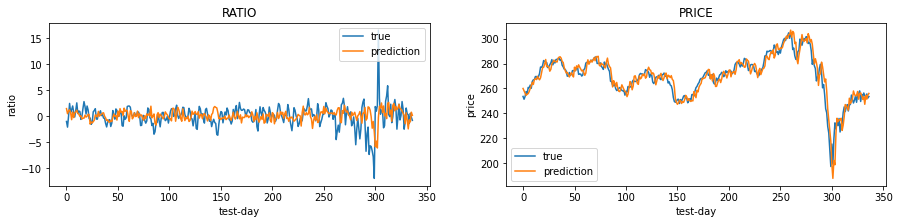

In [21]:
result.evaluation()
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits2)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)